In [10]:
import torch
import torch.nn as nn
# import torchsummary
import torchmetrics
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
plt.rcParams['text.usetex'] = True
from tqdm import tqdm
import os
from h5 import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import time
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [8]:
from triqs.operators import *
from triqs.gf import *
from triqs.gf.descriptors import MatsubaraToLegendre

from triqs_tprf.ParameterCollection import ParameterCollection
from triqs_tprf.ParameterCollection import ParameterCollections


In [9]:
import sys
sys.path.append("./src")

from ml_model import MLSolver   
from DMFT_routins import *
model_path='./models/model_v4'
MLmodel = MLSolver().to(device, torch.float32)
MLmodel.load_checkpoint(checkpoint_path=model_path)


model loaded from ./models/model_v4


In [24]:
def load_db(filename):
    n_entries = 0
    params = 0
    smpls_list = 0
    data2train = []
    with HDFArchive(filename, 'r') as ar:
        n_entries = ar['n_entries']
        params = ar["params"] 
        smpls_list = ar["samples"] 
        # a = smpls_list[0]['pc']
        # print(a.iter)
        # print(params)
        for smpl_id, sample in tqdm(enumerate(smpls_list)):
            ps = sample['pc']
            prms = params[smpl_id]
            dt2train = []

            p = ParameterCollection(
                U = prms['U'],
                mu = 0.,
                n_k = 10,
                n_iter = 7,
                G_l_tol = 5e-3
                )

            p.solve = ParameterCollection(
                length_cycle = 15,
                n_warmup_cycles = 3000,
                n_cycles = int(5e6),
                move_double = False,
                measure_G_l = True,
                verbosity= 2
                )

            p.init = ParameterCollection(
                beta = prms['beta'],
                n_l = 30,
                n_iw = 400,
                n_tau = 4001,
                gf_struct = [('up', 1), ('dn', 1)]
                )

            p0 = setup_dmft_calculation(p, sample['BS'][:, np.newaxis,  np.newaxis])
            p0.n_iter = 10
            ps_ML = solve_self_consistent_dmftML(p0, MLmodel)
            sigmaML = np.real(ps_ML[-1].sigma_w.data.flatten()[400:])
            sigmaEx = np.real(ps[-1].sigma_w.data.flatten()[400:])
            grid = 2.*np.pi/prms['beta']
            Zex = 1./(1. - (sigmaEx[4] - sigmaEx[0])/grid/4.0)
            Zml = 1./(1. - (sigmaML[4] - sigmaML[0])/grid/4.0)


            for p in ps:
                dt2train.append(
                    [ 
                        [p.time2solve, p.averageorder],
                        [prms['U'], prms['beta'], p.g0_l.data.flatten()[:30]],
                        [ p.g_l.data.flatten()[:30]],
                        [Zex, Zml]
                    ]
                )
            
            
            data2train.extend(dt2train)
    return data2train

# db_names = [
#     'database_v4.h5',
#     'database_v5.h5',
#     'database_v6.h5'
#             ]
db_names = ['./data/databaseV14.h5',
            './data/databaseV15.h5']
data_list = [load_db(db_name) for db_name in db_names]
data = []
for dataq in data_list:
    data.extend(dataq)
print(len(data))

1it [00:00,  4.34it/s]

--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.900131
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.385237
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.098067
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.024321
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.006407
--> DMFT Iteration: 5
--> DMFT Convergence: dG_l = 0.001511
--> DMFT Converged: dG_l = 0.001511
--> DMFT Iteration: 0


2it [00:00,  4.81it/s]

--> DMFT Convergence: dG_l = 3.305005
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.296497
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.040147
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.010773
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.001553
--> DMFT Converged: dG_l = 0.001553
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.644384
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.060538
--> DMFT Iteration: 2


4it [00:00,  5.87it/s]

--> DMFT Convergence: dG_l = 0.009131
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000722
--> DMFT Converged: dG_l = 0.000722
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.051952
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.264754
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.012898
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001916
--> DMFT Converged: dG_l = 0.001916
--> DMFT Iteration: 0


5it [00:00,  6.10it/s]

--> DMFT Convergence: dG_l = 2.046539
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.218975
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.027220
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.004921
--> DMFT Converged: dG_l = 0.004921
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.897636
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.164306
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.011720
--> DMFT Iteration: 3


7it [00:01,  6.38it/s]

--> DMFT Convergence: dG_l = 0.003530
--> DMFT Converged: dG_l = 0.003530
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.299694
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.088434
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.010118
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001718
--> DMFT Converged: dG_l = 0.001718
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.358487
--> DMFT Iteration: 1


8it [00:01,  6.44it/s]

--> DMFT Convergence: dG_l = 0.077377
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.007690
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000664
--> DMFT Converged: dG_l = 0.000664
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.520368
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.168472
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.036644
--> DMFT Iteration: 3


10it [00:01,  6.21it/s]

--> DMFT Convergence: dG_l = 0.008098
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003972
--> DMFT Converged: dG_l = 0.003972
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.458132
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.112008
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.016395
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001923
--> DMFT Converged: dG_l = 0.001923
--> DMFT Iteration: 0


11it [00:01,  6.31it/s]

--> DMFT Convergence: dG_l = 2.022424
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.086267
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.014154
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001750
--> DMFT Converged: dG_l = 0.001750
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.739962
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.152943
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.023545
--> DMFT Iteration: 3


13it [00:02,  6.40it/s]

--> DMFT Convergence: dG_l = 0.004023
--> DMFT Converged: dG_l = 0.004023
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.462020
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.122563
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.008319
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000663
--> DMFT Converged: dG_l = 0.000663
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.557037
--> DMFT Iteration: 1


14it [00:02,  6.48it/s]

--> DMFT Convergence: dG_l = 0.184474
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.019861
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.002950
--> DMFT Converged: dG_l = 0.002950
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.692921
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.192803
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.040769
--> DMFT Iteration: 3


16it [00:02,  6.65it/s]

--> DMFT Convergence: dG_l = 0.004124
--> DMFT Converged: dG_l = 0.004124
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.238544
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.170344
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.012566
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000815
--> DMFT Converged: dG_l = 0.000815
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.772410
--> DMFT Iteration: 1


17it [00:02,  6.17it/s]

--> DMFT Convergence: dG_l = 0.289395
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.038636
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.006416
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.000993
--> DMFT Converged: dG_l = 0.000993
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.569440
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.147964
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.030478
--> DMFT Iteration: 3


19it [00:03,  6.86it/s]

--> DMFT Convergence: dG_l = 0.002508
--> DMFT Converged: dG_l = 0.002508
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.332165
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.061001
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.003810
--> DMFT Converged: dG_l = 0.003810
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.839793
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.659508
--> DMFT Iteration: 2


20it [00:03,  5.54it/s]

--> DMFT Convergence: dG_l = 0.137101
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.050098
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.027968
--> DMFT Iteration: 5
--> DMFT Convergence: dG_l = 0.010261
--> DMFT Iteration: 6
--> DMFT Convergence: dG_l = 0.003014
--> DMFT Converged: dG_l = 0.003014
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.248054
--> DMFT Iteration: 1


21it [00:03,  5.46it/s]

--> DMFT Convergence: dG_l = 0.231936
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.073281
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.009949
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.001162
--> DMFT Converged: dG_l = 0.001162
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.544973
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.453562
--> DMFT Iteration: 2


22it [00:03,  5.42it/s]

--> DMFT Convergence: dG_l = 0.091948
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.019433
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.002885
--> DMFT Converged: dG_l = 0.002885
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.598440
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.295127
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.041135
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.006543
--> DMFT Iteration: 4


24it [00:04,  5.72it/s]

--> DMFT Convergence: dG_l = 0.001461
--> DMFT Converged: dG_l = 0.001461
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.378348
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.225414
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.040648
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.003762
--> DMFT Converged: dG_l = 0.003762
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.783562
--> DMFT Iteration: 1


26it [00:04,  6.04it/s]

--> DMFT Convergence: dG_l = 0.038650
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.003317
--> DMFT Converged: dG_l = 0.003317
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.511495
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.514521
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.022389
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.005284
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.001090
--> DMFT Converged: dG_l = 0.001090
--> DMFT Iteration: 0


27it [00:04,  5.73it/s]

--> DMFT Convergence: dG_l = 2.943403
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.229572
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.053840
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.006193
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.000703
--> DMFT Converged: dG_l = 0.000703
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.758603
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.318991
--> DMFT Iteration: 2


28it [00:04,  5.55it/s]

--> DMFT Convergence: dG_l = 0.060577
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.010487
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.001537
--> DMFT Converged: dG_l = 0.001537
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.767000
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.093416
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.007303
--> DMFT Iteration: 3


30it [00:04,  6.48it/s]

--> DMFT Convergence: dG_l = 0.000761
--> DMFT Converged: dG_l = 0.000761
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.748778
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.049236
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.003145
--> DMFT Converged: dG_l = 0.003145
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.634679
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.072248
--> DMFT Iteration: 2


32it [00:05,  6.54it/s]

--> DMFT Convergence: dG_l = 0.005291
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000440
--> DMFT Converged: dG_l = 0.000440
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.221818
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.166383
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.022591
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.003097
--> DMFT Converged: dG_l = 0.003097
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.669082
--> DMFT Iteration: 1


33it [00:05,  6.54it/s]

--> DMFT Convergence: dG_l = 0.176066
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.014642
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.002793
--> DMFT Converged: dG_l = 0.002793
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.636942
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.362771
--> DMFT Iteration: 2


34it [00:05,  6.30it/s]

--> DMFT Convergence: dG_l = 0.014384
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001082
--> DMFT Converged: dG_l = 0.001082
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.621054
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.248297
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.084320
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.008481
--> DMFT Iteration: 4


36it [00:05,  5.59it/s]

--> DMFT Convergence: dG_l = 0.000715
--> DMFT Converged: dG_l = 0.000715
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.326305
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.335691
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.049727
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.013135
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003183
--> DMFT Converged: dG_l = 0.003183
--> DMFT Iteration: 0


37it [00:06,  5.40it/s]

--> DMFT Convergence: dG_l = 2.241239
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.230633
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.032442
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.008028
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.002027
--> DMFT Converged: dG_l = 0.002027
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.744082
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.102239
--> DMFT Iteration: 2


38it [00:06,  5.63it/s]

--> DMFT Convergence: dG_l = 0.018382
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001666
--> DMFT Converged: dG_l = 0.001666
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.804730
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.264145
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.049275
--> DMFT Iteration: 3


39it [00:06,  5.35it/s]WARNING: Direct Fourier cannot deduce the high-frequency moments of G(tau) due to noise or a coarse tau-grid. 	  Please specify the high-frequency moments for higher accuracy.
40it [00:06,  5.61it/s]

--> DMFT Convergence: dG_l = 0.007246
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.000684
--> DMFT Converged: dG_l = 0.000684
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.798970
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.058822
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.005346
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000396
--> DMFT Converged: dG_l = 0.000396
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.393801
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.409564
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.135650
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.027852
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.009601
--> DMFT Iteration: 5


42it [00:07,  5.17it/s]

--> DMFT Convergence: dG_l = 0.001902
--> DMFT Converged: dG_l = 0.001902
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.889266
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.292618
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.108701
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.019537
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.004025
--> DMFT Converged: dG_l = 0.004025
--> DMFT Iteration: 0


43it [00:07,  5.39it/s]

--> DMFT Convergence: dG_l = 2.359797
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.238581
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.026045
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.003738
--> DMFT Converged: dG_l = 0.003738
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.279053
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.227965
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.018244
--> DMFT Iteration: 3


45it [00:07,  5.67it/s]

--> DMFT Convergence: dG_l = 0.002045
--> DMFT Converged: dG_l = 0.002045
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.829580
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.302753
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.015030
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000901
--> DMFT Converged: dG_l = 0.000901
--> DMFT Iteration: 0


46it [00:07,  5.43it/s]

--> DMFT Convergence: dG_l = 3.405688
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.238037
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.075495
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.012354
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.001279
--> DMFT Converged: dG_l = 0.001279
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.987248
--> DMFT Iteration: 1


47it [00:08,  5.31it/s]

--> DMFT Convergence: dG_l = 0.437311
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.122882
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.020761
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003179
--> DMFT Converged: dG_l = 0.003179
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.819313
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.468475
--> DMFT Iteration: 2


48it [00:08,  5.27it/s]

--> DMFT Convergence: dG_l = 0.098508
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.023207
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003801
--> DMFT Converged: dG_l = 0.003801
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.486049
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.197724
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.036505
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.007447
--> DMFT Iteration: 4


50it [00:08,  5.85it/s]

--> DMFT Convergence: dG_l = 0.001672
--> DMFT Converged: dG_l = 0.001672
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.815371
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.056656
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.001382
--> DMFT Converged: dG_l = 0.001382



1it [00:00,  5.32it/s]

--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.263166
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.268206
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.040943
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.006312
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.000865
--> DMFT Converged: dG_l = 0.000865
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.169302
--> DMFT Iteration: 1


2it [00:00,  6.00it/s]

--> DMFT Convergence: dG_l = 0.153221
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.011690
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001620
--> DMFT Converged: dG_l = 0.001620
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.949013
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.484102
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.130807
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.018492
--> DMFT Iteration: 4


3it [00:00,  5.67it/s]

--> DMFT Convergence: dG_l = 0.003204
--> DMFT Converged: dG_l = 0.003204
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.185853
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.502240
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.133021
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.030332
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.008248
--> DMFT Iteration: 5


5it [00:00,  5.17it/s]

--> DMFT Convergence: dG_l = 0.002690
--> DMFT Converged: dG_l = 0.002690
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.845407
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.182442
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.070024
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.010766
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.001745
--> DMFT Converged: dG_l = 0.001745
--> DMFT Iteration: 0


6it [00:01,  5.77it/s]

--> DMFT Convergence: dG_l = 1.818979
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.052698
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.004199
--> DMFT Converged: dG_l = 0.004199
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.837577
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.207694
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.025423
--> DMFT Iteration: 3


8it [00:01,  5.69it/s]

--> DMFT Convergence: dG_l = 0.004172
--> DMFT Converged: dG_l = 0.004172
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.083398
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.418522
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.152505
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.026296
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.004229
--> DMFT Converged: dG_l = 0.004229
--> DMFT Iteration: 0


9it [00:01,  5.93it/s]

--> DMFT Convergence: dG_l = 2.079546
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.171651
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.016834
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001593
--> DMFT Converged: dG_l = 0.001593
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.104761
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.171143
--> DMFT Iteration: 2


11it [00:01,  5.83it/s]

--> DMFT Convergence: dG_l = 0.015282
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.002426
--> DMFT Converged: dG_l = 0.002426
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.223871
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.328624
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.074225
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.010747
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003766
--> DMFT Converged: dG_l = 0.003766
--> DMFT Iteration: 0


12it [00:02,  5.63it/s]

--> DMFT Convergence: dG_l = 1.750868
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.207141
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.033579
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.008933
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.001577
--> DMFT Converged: dG_l = 0.001577
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.285030
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.095620
--> DMFT Iteration: 2


13it [00:02,  5.49it/s]

--> DMFT Convergence: dG_l = 0.029922
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.005870
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.000913
--> DMFT Converged: dG_l = 0.000913
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.354665
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.285113
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.088093
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.012715
--> DMFT Iteration: 4


15it [00:02,  5.77it/s]

--> DMFT Convergence: dG_l = 0.001545
--> DMFT Converged: dG_l = 0.001545
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.562027
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.067610
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.005384
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000235
--> DMFT Converged: dG_l = 0.000235
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.444227
--> DMFT Iteration: 1


17it [00:02,  6.63it/s]

--> DMFT Convergence: dG_l = 0.194703
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.023540
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.004397
--> DMFT Converged: dG_l = 0.004397
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.624946
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.065031
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.004510
--> DMFT Converged: dG_l = 0.004510
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.704923
--> DMFT Iteration: 1


18it [00:03,  6.18it/s]

--> DMFT Convergence: dG_l = 0.250291
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.066444
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.011925
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003453
--> DMFT Converged: dG_l = 0.003453
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.405038
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.159615
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.014668
--> DMFT Iteration: 3


20it [00:03,  5.97it/s]

--> DMFT Convergence: dG_l = 0.000875
--> DMFT Converged: dG_l = 0.000875
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.997284
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.165943
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.042944
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.009111
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003155
--> DMFT Converged: dG_l = 0.003155
--> DMFT Iteration: 0


21it [00:03,  6.19it/s]

--> DMFT Convergence: dG_l = 1.607034
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.091672
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.009156
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001896
--> DMFT Converged: dG_l = 0.001896
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.926185
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.193027
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.028693
--> DMFT Iteration: 3


22it [00:03,  5.90it/s]

--> DMFT Convergence: dG_l = 0.006255
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.000934
--> DMFT Converged: dG_l = 0.000934
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.421131
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.345036
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.094975
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.023974
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.005511
--> DMFT Iteration: 5


24it [00:04,  5.32it/s]

--> DMFT Convergence: dG_l = 0.001042
--> DMFT Converged: dG_l = 0.001042
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.253617
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.198041
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.062508
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.012140
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.002389
--> DMFT Converged: dG_l = 0.002389
--> DMFT Iteration: 0


25it [00:04,  5.64it/s]

--> DMFT Convergence: dG_l = 4.279605
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.218341
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.017869
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.002274
--> DMFT Converged: dG_l = 0.002274
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.581662
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.494093
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.154728
--> DMFT Iteration: 3


26it [00:04,  5.20it/s]

--> DMFT Convergence: dG_l = 0.029721
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.005076
--> DMFT Iteration: 5
--> DMFT Convergence: dG_l = 0.001730
--> DMFT Converged: dG_l = 0.001730
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 4.042935
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.333425
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.074079
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.013924
--> DMFT Iteration: 4


28it [00:04,  5.32it/s]

--> DMFT Convergence: dG_l = 0.002369
--> DMFT Converged: dG_l = 0.002369
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.574549
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.299944
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.047602
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.010108
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003363
--> DMFT Converged: dG_l = 0.003363
--> DMFT Iteration: 0


29it [00:05,  6.07it/s]

--> DMFT Convergence: dG_l = 1.811356
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.032802
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.002194
--> DMFT Converged: dG_l = 0.002194
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.836270
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.318161
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.035462
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.006292
--> DMFT Iteration: 4


31it [00:05,  5.67it/s]

--> DMFT Convergence: dG_l = 0.000642
--> DMFT Converged: dG_l = 0.000642
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.261172
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.378774
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.051370
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.012118
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.002712
--> DMFT Converged: dG_l = 0.002712
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.559048
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.453462
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.152351
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.200463
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.847432
--> DMFT Iteration: 5
--> DMFT Convergence: dG_l = 0.522512
--> DMFT Iteration: 6
--> DMFT Convergence: dG_l = 0.349148
--> DMFT Iteration: 7


32it [00:05,  4.24it/s]

--> DMFT Convergence: dG_l = 0.315048
--> DMFT Iteration: 8
--> DMFT Convergence: dG_l = 0.529530
--> DMFT Iteration: 9
--> DMFT Convergence: dG_l = 0.464862
--> Warning: DMFT Not converged!
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.283004
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.157797
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.061309
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.008064
--> DMFT Iteration: 4


34it [00:06,  5.24it/s]

--> DMFT Convergence: dG_l = 0.001185
--> DMFT Converged: dG_l = 0.001185
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.385390
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.044303
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.001593
--> DMFT Converged: dG_l = 0.001593
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.386954
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.066408
--> DMFT Iteration: 2


35it [00:06,  5.58it/s]

--> DMFT Convergence: dG_l = 0.006554
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000332
--> DMFT Converged: dG_l = 0.000332
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.846837
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.230532
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.037701
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.005421
--> DMFT Iteration: 4


37it [00:06,  5.75it/s]

--> DMFT Convergence: dG_l = 0.000732
--> DMFT Converged: dG_l = 0.000732
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.114770
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.249705
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.047104
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.004692
--> DMFT Converged: dG_l = 0.004692
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.208579
--> DMFT Iteration: 1


38it [00:06,  5.62it/s]

--> DMFT Convergence: dG_l = 0.327207
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.054141
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.013443
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003392
--> DMFT Converged: dG_l = 0.003392
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.355997
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.223364
--> DMFT Iteration: 2


40it [00:07,  5.70it/s]

--> DMFT Convergence: dG_l = 0.018463
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001903
--> DMFT Converged: dG_l = 0.001903
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.451571
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.341435
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.066679
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.021329
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.003505
--> DMFT Converged: dG_l = 0.003505
--> DMFT Iteration: 0


42it [00:07,  6.44it/s]

--> DMFT Convergence: dG_l = 2.327192
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.051736
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.003998
--> DMFT Converged: dG_l = 0.003998
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.017463
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.061426
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.007494
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001621
--> DMFT Converged: dG_l = 0.001621
--> DMFT Iteration: 0


43it [00:07,  6.05it/s]

--> DMFT Convergence: dG_l = 2.418508
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.472355
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.057369
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.008101
--> DMFT Iteration: 4
--> DMFT Convergence: dG_l = 0.000845
--> DMFT Converged: dG_l = 0.000845
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.482475
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.101959
--> DMFT Iteration: 2


45it [00:07,  6.34it/s]

--> DMFT Convergence: dG_l = 0.010322
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001733
--> DMFT Converged: dG_l = 0.001733
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 3.804358
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.177850
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.044277
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.003602
--> DMFT Converged: dG_l = 0.003602
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.623319
--> DMFT Iteration: 1


47it [00:08,  6.85it/s]

--> DMFT Convergence: dG_l = 0.061430
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.004902
--> DMFT Converged: dG_l = 0.004902
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.861669
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.126140
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.012052
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000966
--> DMFT Converged: dG_l = 0.000966
--> DMFT Iteration: 0


48it [00:08,  6.67it/s]

--> DMFT Convergence: dG_l = 2.636972
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.373716
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.015172
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001171
--> DMFT Converged: dG_l = 0.001171
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 1.348867
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.071109
--> DMFT Iteration: 2


50it [00:08,  5.81it/s]

--> DMFT Convergence: dG_l = 0.006463
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.000536
--> DMFT Converged: dG_l = 0.000536
--> DMFT Iteration: 0
--> DMFT Convergence: dG_l = 2.879270
--> DMFT Iteration: 1
--> DMFT Convergence: dG_l = 0.114538
--> DMFT Iteration: 2
--> DMFT Convergence: dG_l = 0.019040
--> DMFT Iteration: 3
--> DMFT Convergence: dG_l = 0.001287
--> DMFT Converged: dG_l = 0.001287
443


In [12]:
# def load_db(filename):
#     n_entries = 0
#     params = 0
#     smpls_list = 0
#     with HDFArchive(filename, 'r') as ar:
#         n_entries = ar['n_entries']
#         params = ar["params"] 
#         smpls_list = ar["samples"] 
#     # print(params)
#     data2train = [ [[sample['time2solve'], sample['averageorder']],
#                     [params[smpl_id]['U'], params[smpl_id]['beta'], 
#                       np.real(sample['G0_l'].data).flatten()[:30]], 
#                     [ np.real(sample['G_l'].data).flatten()]]  
#                   for smpl_id, sample in enumerate(smpls_list)] 
#     return data2train

# # db_names = [
# #     'database_v4.h5',
# #     'database_v5.h5',
# #     'database_v6.h5'
# #             ]
# db_names = ['./data/databaseV8.h5',
#             './data/databaseV9.h5',
#             './data/databaseV10.h5',
#             './data/databaseV11.h5']
# data_list = [load_db(db_name) for db_name in db_names]
# data = []
# for dataq in data_list:
#     data.extend(dataq)
# print(len(data))

In [26]:
U       = np.array([sample[1][0] for sample in data])
beta    = np.array([sample[1][1] for sample in data])
times   = np.array([sample[0][0] for sample in data])
order   = np.array([sample[0][1] for sample in data])

Zex   = np.array([sample[3][0] for sample in data])
Zml   = np.array([sample[3][1] for sample in data])


(1.05, 1.15)

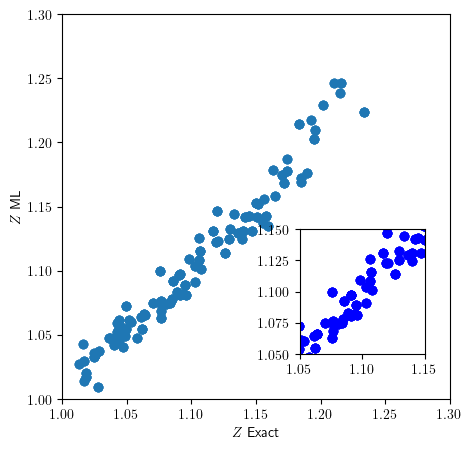

In [36]:
fig, ax = plt.subplots( figsize=(5, 5))

ax.scatter(Zex, Zml)
ax.set_ylabel(r'$Z$ ML')
ax.set_xlabel(r'$Z$ Exact')
ax.set_xlim([1, 1.3])
ax.set_ylim([1, 1.3])


inset_ax = fig.add_axes([0.6, 0.2, 0.25, 0.25])  # [left, bottom, width, height]
inset_ax.scatter(Zex, Zml, color='blue')
inset_ax.set_xlim([1.05, 1.15])
inset_ax.set_ylim([1.05, 1.15])
